In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('homework2.ok')

Assignment: homework2
OK, version v1.14.11



# Homework 2: Exploratory Data Analysis in Professional Basketball

In this assignment we'll conduct an exploratory data analysis of professional basketball data.  Basketball is a team sport in which the goal is to try to outscore the amount in a fixed amount of time. Points are scored (either 2 or 3 points) by putting the ball throw a hoop on one end of the court.  An attempt at putting the ball throw the hoop is known as a "shot".  If helpful, you can read more about [the rules of basketball](https://en.wikipedia.org/wiki/Rules_of_basketball).

The National Basketball Association (NBA) is the professional basketball league in the United States and provides a nice website with many statistics gathered on teams and players in the league: [http://stat.nba.com](http://stat.nba.com). 

## Part 1: Getting the Data

As an example, in order to navigate to the shooting records for Stephen Curry, one of the most famous players, you navigate their menus to get to here:

> [http://stats.nba.com/player/201939/shooting/?Season=2018-19&SeasonType=Regular%20Season](http://stats.nba.com/player/201939/shooting/?Season=2018-19&SeasonType=Regular%20Season)

Here, we see some information related to our choices:
- Season: 2018-19
- SeasonType: Regular Season (Note that [%20 is character code for space](https://en.wikipedia.org/wiki/Percent-encoding#Character_data))
- Player: 201939 (less obvious)

This type of URL is using a [GET method](https://www.w3schools.com/tags/ref_httpmethods.asp). When your URLs are very long, it is usually passing a series of variables and values to the web page. There are tools such as this [online URL parser](https://www.freeformatter.com/url-parser-query-string-splitter.html). Try passing in the URL.

Knowledge of how web sites work is useful for data science since there is so much interaction through the web.

We've provided a function that requests data from `stats.nba.com`. 

**User agent**: Inside the function there is a string variable for what is called a User Agent. Suitably setting this user agent string allows you to mimic any browser. Websites can return different content depending on the browser (i.e. user agent) users use to connect.  In the case of stats.nba.com, they block programatic scraping their pages using `wget` (with user agent, "Wget/1.19.4 (linux-gnu)" if you are using the course server) However, by specifying the user agent string in `get_nba_data`, we pretend that our connection is from a user using a Mozilla-type browser on OS X. 

**End point**: NBA has many different data: e.g., teams, players, games, etc. An end point is a URL designated for a specific type of data they provide. For example, a GET URL using `http://stats.nba.com/stats/commonallplayers` as the base URL will return players data. Other end points are listed here: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation.

Unfortunately, NBA seem have blocked the IP of the PSTAT 134/234 cluster.  You can use the function on you own machine if python, [IPython](https://ipython.readthedocs.io/en/stable/interactive/python-ipython-diff.html#shell-assignment), and `wget` utility are installed.

The function will do the following:
1. Set User Agent
1. Set base URL with appropriate end point
1. Set parameters required for query
1. Read JSON string into python variable
1. Parse JSON string into python object
1. Convert the objects into pandas a data frame

In [2]:
def get_nba_data(endpt, params, return_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}
    
    from pandas import DataFrame
    from urllib.parse import urlencode
    import json
    
    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""
    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(DataFrame(d, columns=h))

The function fetches the JSON and converts the JSON to a DataFrame that we can manipulate.  JSON format is very similar to Python dictionary: i.e., keys and values.  There are built-in libraries to work with json files formats. We read the output of `wget` command into a python variable: `json_str`. We parse that string with the `json` library.  First we load the necessary pacakges:

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import pickle # to serialize/unserialize python data objects


In [4]:
## get all 2018-19 teams
if False:
    params = {'LeagueID':'00','Season': '2018-19'}
    teams = get_nba_data('commonTeamYears', params).set_index('TEAM_ID')
    allteams = teams.loc[teams.MAX_YEAR=='2018'].index.values

    pickle.dump(allteams, open( "allteams2018.p", "wb" ) )
  
## downloads allteams2018.p if needed
!wget -q -nc https://ucsb.box.com/shared/static/bqvt4sroarfchdy8ol01d9cv0yvmcdxk.p \
    -O allteams2018.p

allteams = ...

The code below won't run on the PSTAT 134/234 server.  If you have python installed on your local machine you can try scraping this data yourself!

In [5]:
if False:
    ## get all 2018-19 player ids
    params = {'LeagueID':'00', 'Season': '2018-19', 'IsOnlyCurrentSeason': '0'}
    players = get_nba_data('commonallplayers', params).set_index('PERSON_ID')

    # Player ids and names
    allplyrs = players.loc[players.TEAM_ID.isin(allteams)]['DISPLAY_FIRST_LAST'].drop_duplicates()

    ## save in a pickle file
    pickle.dump(allplyrs, open( "allplyrs2018.p", "wb" ) )

### Question 1a

Load the pickle titled `allplyrs2018.p` into a pandas dataframe called `allplyrs`:

<!--
BEGIN QUESTION
name: q1a
manual: false
points: 2
-->

In [6]:
# downloads allplyrs1028.p if needed
!wget -q -nc https://ucsb.box.com/shared/static/oicfhmyb5docjnu7nfmhaf3lvafc1am6.p \
    -O allplyrs2018.p

allplyrs = pd.DataFrame(pd.read_pickle("allplyrs2018.p"))

Below are the `params` we'll use for our `json` query.  For now we left `PlayerID` blank.  Most importantly we're querying data from 2018-19 season and looking at field goals: `'ContextMeasure':'FGA'`

In [7]:
params = {'PlayerID':'201939', # We'll fill this in after identifying the right player
          'PlayerPosition':'',
          'Season':'2018-19',
          'ContextMeasure':'FGA',
          'DateFrom':'',
          'DateTo':'',
          'GameID':'',
          'GameSegment':'',
          'LastNGames':'0',
          'LeagueID':'00',
          'Location':'',
          'Month':'0',
          'OpponentTeamID':'0',
          'Outcome':'',
          'Period':'0',
          'Position':'',
          'RookieYear':'',
          'SeasonSegment':'',
          'SeasonType':'Regular Season',
          'TeamID':'0',
          'VsConference':'',
          'VsDivision':''}
 

## Question 1b: Get one player's shot data

Use `allplyrs` to find the player id (index) associated with the player named "[Stephen Curry](https://en.wikipedia.org/wiki/Stephen_Curry)".  Set the value of `PlayerID` in the `params` dictionary to Stephen Curry's id.  

<!--
BEGIN QUESTION
name: q1b
manual: false
points: 2
-->

In [8]:
curry_id = allplyrs.index[allplyrs.DISPLAY_FIRST_LAST == "Stephen Curry"]
curry_id

Int64Index([201939], dtype='int64', name='PERSON_ID')

In [9]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 0
[k..........] 0.0% passed



## Question 1c

The NBA stats page is blocking our jupyter hub server, so `get_nba_data` won't work on https://pstat134.lsit.ucsb.edu/ (if you have python installed on your machine, try it out!).  Instead, call the `get_nba_data` but have it return the url rather than actually query the website for the `json`.  Print the url.

In [10]:
if False:
    ## get shot data for Stephen Curry and pickle it
    curry_data = get_nba_data('shotchartdetail', params, return_url=False)
    pickle.dump(allplyrs, open( "curry2018.p", "wb" ) )
if True: 
    curry_url = get_nba_data('shotchartdetail', params, return_url=True)
print(curry_url)

"http://stats.nba.com/stats/shotchartdetail?PlayerID=201939&PlayerPosition=&Season=2018-19&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&Period=0&Position=&RookieYear=&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision="


Copy `curry_url` and paste it into a new tab in your browser.  This will show you the raw `json` that is being served to us on a successful query.  Save this data as `curry.json` in the current directory.  The code below will load the json file into a dictionary called `curry_json`.  The relevant data is under the key `resultSets`.  `h` will be the headers for this data and `d` will be the values in the table.  Use `h` and `d` to create a pandas data frame named `curry_data`.  Print the first few rows of `curry_data` to inspect it.

In [11]:
import json
with open('curry.json', 'r') as f:
    curry_json = json.load(f)
    
curry_json.keys()

h = curry_json['resultSets'][0]['headers']
d = curry_json['resultSets'][0]['rowSet']

curry_data = pd.DataFrame(d)
curry_data.columns = h
curry_data

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021800002,10,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,31,...,Right Side Center(RC),24+ ft.,24,226,90,1,1,20181016,GSW,OKC
1,Shot Chart Detail,0021800002,58,201939,Stephen Curry,1610612744,Golden State Warriors,1,7,57,...,Center(C),Less Than 8 ft.,6,-2,63,1,1,20181016,GSW,OKC
2,Shot Chart Detail,0021800002,131,201939,Stephen Curry,1610612744,Golden State Warriors,1,3,46,...,Center(C),Less Than 8 ft.,2,5,29,1,1,20181016,GSW,OKC
3,Shot Chart Detail,0021800002,141,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,58,...,Center(C),Less Than 8 ft.,1,-6,18,1,0,20181016,GSW,OKC
4,Shot Chart Detail,0021800002,145,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,49,...,Left Side(L),24+ ft.,22,-228,8,1,1,20181016,GSW,OKC
5,Shot Chart Detail,0021800002,276,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,39,...,Right Side(R),8-16 ft.,9,96,25,1,0,20181016,GSW,OKC
6,Shot Chart Detail,0021800002,293,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,5,...,Left Side Center(LC),24+ ft.,28,-204,195,1,1,20181016,GSW,OKC
7,Shot Chart Detail,0021800002,368,201939,Stephen Curry,1610612744,Golden State Warriors,2,1,3,...,Center(C),Less Than 8 ft.,2,6,25,1,1,20181016,GSW,OKC
8,Shot Chart Detail,0021800002,374,201939,Stephen Curry,1610612744,Golden State Warriors,2,0,44,...,Right Side(R),8-16 ft.,12,113,52,1,0,20181016,GSW,OKC
9,Shot Chart Detail,0021800002,418,201939,Stephen Curry,1610612744,Golden State Warriors,3,9,47,...,Center(C),24+ ft.,28,25,281,1,1,20181016,GSW,OKC


## 1d Investigating the data about the data

A glossary of basketball terms can be found here: https://stats.nba.com/help/glossary/

Here are some of the key ones:
- Field goal: a basketball shot
- FGA: Field Goals Attempted 
- FGM: Field Goals Made


Group the data by `SHOT_ZONE_RANGE` and call the `size()` function on the resulting `groupby` data frame to get the number of shot attempts in different areas of the court.  Save this in `shot_zone_range_df`.  How many shots were taken within 8 feet of the basket? How many shots were taken further than 24 feet from the basket?  Save these in the appropriate variable below.

<!--
BEGIN QUESTION
name: q1d
manual: false
points: 2
-->

In [12]:
shot_zone_range_df = curry_data.groupby(["SHOT_ZONE_RANGE"]).size().reset_index()
shots_inside8 = shot_zone_range_df[shot_zone_range_df.SHOT_ZONE_RANGE == "8-16 ft."]
shots_24plus = shot_zone_range_df[shot_zone_range_df.SHOT_ZONE_RANGE == "24+ ft."]

In [13]:
ok.grade("q1d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q1d > Suite 1 > Case 1

>>> shot_zone_range_df.shape
(5, 2)

# Error: expected
#     (5,)
# but got
#     (5, 2)

Run only this test case with "python3 ok -q q1d --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



## 1e Investigating the data about the data


Lets try a different grouping now.  Group the data by `SHOT_ZONE_AREA` and and use `size()` to get the group counts.  Save this in `shot_zone_area_df` and print it.  How many shots were taken from the left center side or the right center side?

<!--
BEGIN QUESTION
name: q1e
manual: false
points: 2
-->

In [14]:
shot_zone_area_df = curry_data.groupby(["SHOT_ZONE_AREA"]).size().reset_index()
shot_zone_area_df

,SHOT_ZONE_AREA,0
0,Back Court(BC),11
1,Center(C),506
2,Left Side Center(LC),290
3,Left Side(L),127
4,Right Side Center(RC),309
5,Right Side(R),97


*Write your answer here, replacing this text.*

### Question 1f 

Use pivot table to generate a table with entries representing the fraction of attempted shots that were made (i.e. compute the field goal percentage) by both range and area for each period of the game. Set the rows (`index`) to correspond to the `PERIOD` and the columns corresponding to `SHOT_ZONE_RANGE` and `SHOT_ZONE AREA`.  Fill any missing entries in the pivot table by setting an [appropriate argument](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).


<!--
BEGIN QUESTION
name: q1f
manual: false
points: 2
-->

In [15]:
FGpercent_table = curry_data.pivot_table(index = "PERIOD", columns = ["SHOT_ZONE_AREA", "SHOT_ZONE_RANGE"], values = "SHOT_MADE_FLAG", aggfunc = lambda x: sum(x) / np.size(x), fill_value=0)
#FGpercent_table["GOAL_PCT"] = FGpercent_table["sum"] / FGpercent_table["count"]
#FGpercent_table.reset_index(FGpercent_table["PERIOD"])
FGpercent_table

SHOT_ZONE_AREA   Back Court(BC) Center(C)                                      \
SHOT_ZONE_RANGE Back Court Shot 16-24 ft.   24+ ft.  8-16 ft. Less Than 8 ft.   
PERIOD                                                                          
1                      0.333333  0.444444  0.558824  0.571429        0.591837   
2                      0.000000  1.000000  0.406250  0.636364        0.636364   
3                      0.000000  0.428571  0.437500  0.285714        0.573171   
4                      0.000000  0.300000  0.379310  0.400000        0.565217   
5                      0.000000  0.000000  0.666667  0.000000        1.000000   

SHOT_ZONE_AREA  Left Side Center(LC)           Left Side(L)            \
SHOT_ZONE_RANGE            16-24 ft.   24+ ft.    16-24 ft.   24+ ft.   
PERIOD                                                                  
1                           0.200000  0.371795     0.111111  0.636364   
2                           0.625000  0.558824     0.285714  0.437500   
3                           0.333333  0.506849     0.400000  0.500000   
4                           0.666667  0.325000     1.000000  0.461538   
5                           0.000000  0.000000     1.000000  1.000000   

SHOT_ZONE_AREA            Right Side Center(RC)           Right Side(R)  \
SHOT_ZONE_RANGE  8-16 ft.             16-24 ft.   24+ ft.     16-24 ft.   
PERIOD                                                                    
1                0.428571              0.411765  0.387097      1.000000   
2                0.333333              0.533333  0.351852      0.500000   
3                0.727273              0.636364  0.378049      0.500000   
4                0.166667              0.250000  0.467742      0.333333   
5                0.000000              0.000000  0.000000      0.000000   

SHOT_ZONE_AREA                       
SHOT_ZONE_RANGE   24+ ft.  8-16 ft.  
PERIOD                               
1                0.500000  0.500000  
2                0.400000  0.285714  
3                0.619048  0.375000  
4                0.000000  0.500000  
5                0.000000  0.000000

In [16]:
ok.grade("q1f");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 0
[k..........] 0.0% passed



### Question 1e

You are interested in identifying whether Stephen Curry has different behavior in different periods of the game.  In a few sentences, discuss how might you identify whether Curry's shot selection is different early in the game (e.g. periods 1 and 2) than later in the game (e.g. periods 3 and 4)?  This is an open ended question and the answer can include looking at visualizations, statistical tests etc.

*Write your answer here, replacing this text.*

## Part 2: Visualization

### Q2a
Use `seaborn` to create scatter plot of the location of Stephen Curry's shot attempts from this year (`LOC_X` and `LOC_Y`).  When you call a scatterplot, seaborn returns a figure in an object, we'll call it `ax`.  We can set properties of the figure by calling methods on `ax`.  Use this approach to set the x-axis limits to span (-300, 300), the y-axis limits to span (-100, 500).

<!--
BEGIN QUESTION
name: q2a
manual: false
points: 2
-->

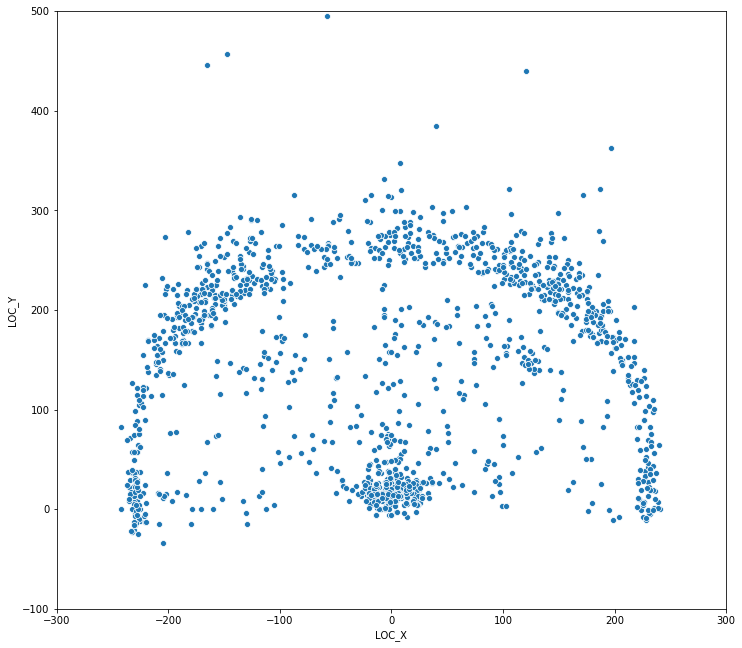

In [18]:
import seaborn as sns

plt.figure(figsize=[12, 11])
ax = sns.scatterplot("LOC_X", "LOC_Y", data = curry_data)
ax.set(xlim = (-300, 300), ylim = (-100, 500));

In [19]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed




Understanding any dataset is hard without context.  Lets add some important context by adding the relevant court lines into our diagram.  If you are interested, you can read more about the lines and dimensions on the [NBA basketball court](https://en.wikipedia.org/wiki/Basketball_court).  We will use code from [http://savvastjortjoglou.com/nba-shot-sharts.html](http://savvastjortjoglou.com/nba-shot-sharts.html) to add the court markings to our diagram.  The `draw_court` function below will do this for us.  The below cell will generate an example court.


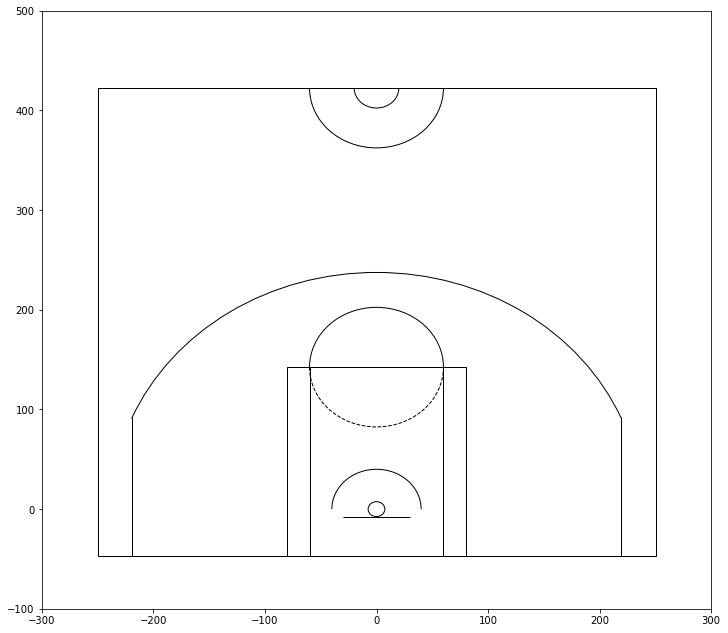

In [20]:
## code is from http://savvastjortjoglou.com/nba-shot-sharts.html
def draw_court(ax=None, color='black', lw=1, outer_lines=False):
    
    from matplotlib.patches import Circle, Rectangle, Arc
    from matplotlib.pyplot import gca
    
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-219, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((219, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.5, theta2=157.5, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

### Q2b

Again use seaborn to make a scatter plot of Stephen Curry's shots. Again, set the x-axis limits to span (-300, 300), the y-axis limits to span (-100, 500) color the points by whether the shot was made or missed.  Set the missed shots to have an 'x' symbol and made shots to be a circular symbol. Call the `draw_court` function with `outer_lines` set to to be true. Save the `Axes` returned by the plot call in a variable called `ax`.

<!--
BEGIN QUESTION
name: q2b
manual: false
points: 2
-->

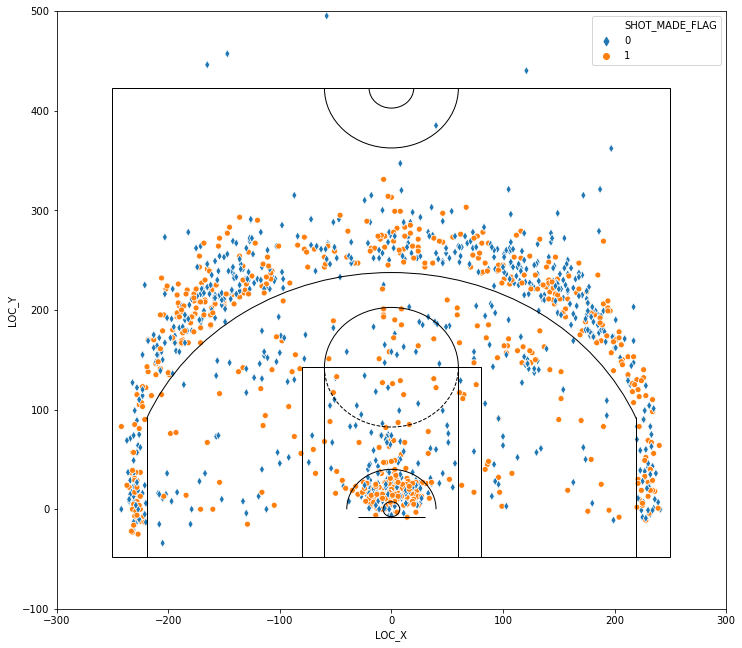

In [23]:
plt.figure(figsize=(12, 11))
cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)
markers = {0: "d", 1: "o"} #I couldn't get marker "X" to work. Apparently there's an ongoing GH dicussion about an error between 0.9.0 and 0.8.1 versions (valueerror: could not convert string to float: 'X')
ax = sns.scatterplot("LOC_X", "LOC_Y",
                     hue = "SHOT_MADE_FLAG",
                     style = "SHOT_MADE_FLAG",
                     markers = markers,
                     data = curry_data)
ax.set(xlim = (-300, 300), ylim = (-100, 500));
draw_court(outer_lines = True);

In [24]:
ok.grade("q2b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Q2c
In a few sentences, discuss what makes this an effective or ineffective visualization for understanding the types of shots that Stephen Curry likes to take and is good at taking, relative to other players in the league.  Are there ways it can be improved?

*Write your answer here, replacing this text.*

### Question 2d: A Hexbin plot

Visualize Stephen Curry's shots by using a [hexbin plot with marginal histograms](https://seaborn.pydata.org/examples/hexbin_marginals.html). Also refer to setting [figure aesthetics](https://seaborn.pydata.org/tutorial/aesthetics.html) for what commands below do.

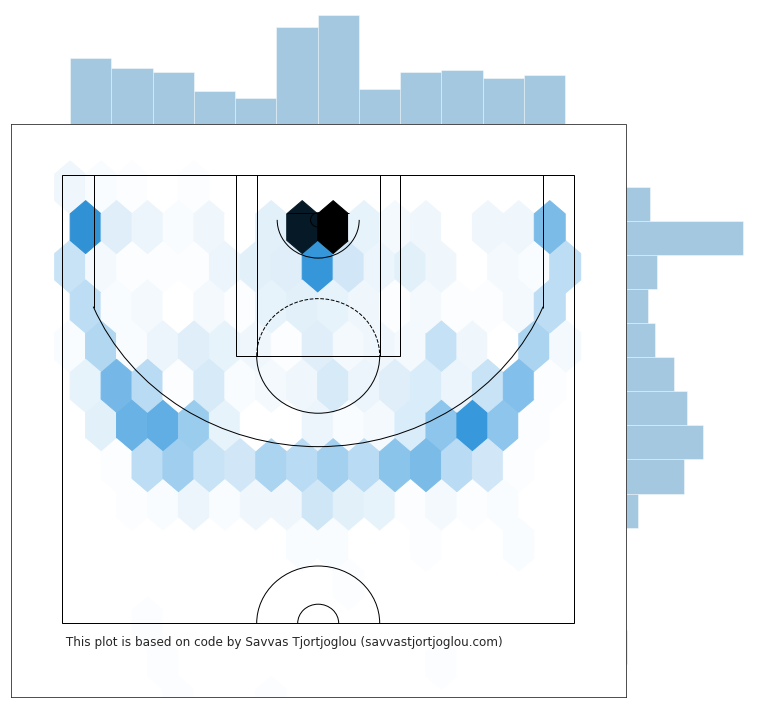

In [25]:
sns.set_style("white")
joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=curry_data, kind='hex', space=0)
joint_shot_chart.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax, outer_lines=True)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-300, 300)
ax.set_ylim(500, -100)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom=False, labelleft=False)

# Add a title
ax.set_title('Stephen Curry, 2018-19, FGA', 
             y=1.2, fontsize=18)

# Add Data Scource and Author
ax.text(-250,445,'\n This plot is based on code by Savvas Tjortjoglou (savvastjortjoglou.com)',
        fontsize=12);

## Question 3: Analyzing Shots from All Players


As a reminder, we've already gathered a list of all player names and ids in the `allplyrs` object.  The code below in the `if False` look will not run on https://pstat134.lsit.ucsb.edu/, but if you run it locally, it will loops over all player ids and grabs the `shotchartdetail` from [stats.nba.com](https://stats.nba.com). We've done this step and stored the pandas data frame of all shot data in `allshots2018.p`. Load this pickle file into a DataFrame titled `allshots`.


In [26]:
if False:
    params = {'PlayerID':'',
              'PlayerPosition':'',
              'Season':'2018-19',
              'ContextMeasure':'FGA',
              'DateFrom':'',
              'DateTo':'',
              'GameID':'',
              'GameSegment':'',
              'LastNGames':'0',
              'LeagueID':'00',
              'Location':'',
              'Month':'0',
              'OpponentTeamID':'0',
              'Outcome':'',
              'Period':'0',
              'Position':'',
              'RookieYear':'',
              'SeasonSegment':'',
              'SeasonType':'Regular Season',
              'TeamID':'0',
              'VsConference':'',
              'VsDivision':''}

    shotdf = []
    for p in allplyrs.index.values:
        print(p)

        # get player p's data
        params['PlayerID'] = p
        
        # scrape the json data
        playerdata = get_nba_data('shotchartdetail', params)
        
        # add playerID to the dictionary
        playerdata['PlayerID'] = p
        
        # add to the list of player data frames
        shotdf += [playerdata]
    
    # This concats a list of data frame's into one big data frame
    allshots = pd.concat(shotdf)

    # Save the json
    pickle.dump(allshots, open('allshots2018.p', 'wb'))
    
if True:
    
    # Downloads allshots2018.p if needed
    !wget -q -nc https://ucsb.box.com/shared/static/c8e402js320ejse3txxpdp84m1qy88q0.p \
        -O allshots2018.p
    
    allshots = pd.DataFrame(pd.read_pickle("allshots2018.p"))

allshots

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,PlayerID
0,Shot Chart Detail,0021800007,732,1629121,Jaylen Adams,1610612737,Atlanta Hawks,4,0,19,...,24+ ft.,23,232,39,1,0,20181017,NYK,ATL,1629121
1,Shot Chart Detail,0021800088,699,1629121,Jaylen Adams,1610612737,Atlanta Hawks,4,2,52,...,24+ ft.,26,145,219,1,0,20181029,PHI,ATL,1629121
2,Shot Chart Detail,0021800088,717,1629121,Jaylen Adams,1610612737,Atlanta Hawks,4,1,4,...,24+ ft.,24,235,51,1,1,20181029,PHI,ATL,1629121
3,Shot Chart Detail,0021800097,691,1629121,Jaylen Adams,1610612737,Atlanta Hawks,4,1,21,...,24+ ft.,25,-153,209,1,0,20181030,CLE,ATL,1629121
4,Shot Chart Detail,0021800412,525,1629121,Jaylen Adams,1610612737,Atlanta Hawks,4,11,26,...,16-24 ft.,18,-188,25,1,0,20181212,DAL,ATL,1629121
5,Shot Chart Detail,0021800436,704,1629121,Jaylen Adams,1610612737,Atlanta Hawks,4,0,32,...,24+ ft.,25,161,194,1,1,20181216,BKN,ATL,1629121
6,Shot Chart Detail,0021800653,299,1629121,Jaylen Adams,1610612737,Atlanta Hawks,2,3,17,...,24+ ft.,25,89,241,1,0,20190115,ATL,OKC,1629121
7,Shot Chart Detail,0021800653,320,1629121,Jaylen Adams,1610612737,Atlanta Hawks,2,0,57,...,Less Than 8 ft.,1,2,13,1,0,20190115,ATL,OKC,1629121
8,Shot Chart Detail,0021800653,458,1629121,Jaylen Adams,1610612737,Atlanta Hawks,3,3,46,...,16-24 ft.,22,99,204,1,0,20190115,ATL,OKC,1629121
9,Shot Chart Detail,0021800653,605,1629121,Jaylen Adams,1610612737,Atlanta Hawks,4,6,7,...,16-24 ft.,21,163,141,1,1,20190115,ATL,OKC,1629121


### Q3a

From all shots taken in 2018-2019, create a DataFrame `shot_counts` of shots taken in each zone range and area combination. Then, calculate the fraction of shots taken from range `24+ ft.` in the `Center(C)` shot area.

<!--
BEGIN QUESTION
name: q3a
manual: false
points: 2
-->

In [28]:
shot_counts = allshots.groupby(["SHOT_ZONE_RANGE", "SHOT_ZONE_AREA"], as_index = False).agg({"SHOT_ATTEMPTED_FLAG": "size"})

frac_center24 = shot_counts.SHOT_ATTEMPTED_FLAG[(shot_counts.SHOT_ZONE_RANGE == "24+ ft.") & (shot_counts.SHOT_ZONE_AREA == "Center(C)")] / shot_counts.SHOT_ATTEMPTED_FLAG.sum()

In [29]:
ok.grade("q3a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 0
[k..........] 0.0% passed



### Question 3b

Make a histogram of the number of total shots taken across all players **with 15 bins**.  Label the x-axis appropriately, set the color of the bars to green.

<!--
BEGIN QUESTION
name: q3b
manual: false
points: 2
-->

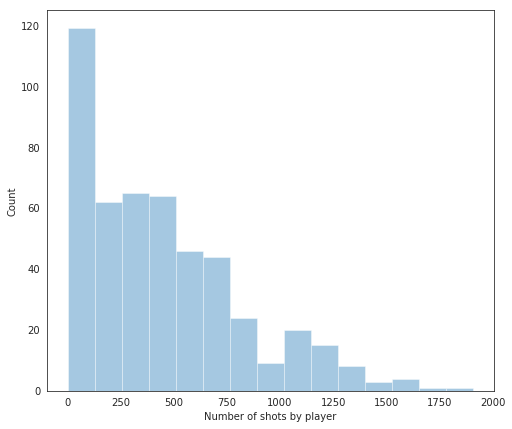

In [30]:
plt.figure(figsize=(8, 7))
ply_shots = allshots.groupby("PLAYER_NAME", as_index = False).agg({"SHOT_ATTEMPTED_FLAG": "size"})
ply_shots
ax = sns.distplot(ply_shots.SHOT_ATTEMPTED_FLAG, kde = False, bins = 15)
ax.set(xlabel = "Number of shots by player", ylabel = "Count");

## Q3c

What do you observe about the distribution of shot attempts in the NBA across all players? Why might this be? Discuss in 1-3 sentences below.

*Write your answer here, replacing this text.*

## Question 4: Binning and Smoothing Shots

So far, in we have worked with dataframes which represent each shot as a single observation (row) within the dataset.  However, this isn't a convenient data structure for the kinds of spatial analyses we will puruse below.  In this part, we will divide the court into square regions and create a matrix which includes the number of shots taken by a player in that region.  We divide the court up into square bins (e.g. a 2d histogram), and, for each player, count number of shots that fall into each bin. Fortunately, this function is relatively simple to write using existing `numpy` functions. 

### Q4a


Fill in the `bin_shots` function below. Use `np.histgram2d` to count count the shots in each bin.  The bins are defined `bin_edges` which is a pandas Series of the form `(xedges, yedges)`.  If `density = True`, call `ndimage.filters.gaussian_filter` on the result of `np.histogram2d` with smoothing parameter `sigma`.  This will create a smoothed version of the raw data histograms.

<!--
BEGIN QUESTION
name: q4a
manual: false
points: 2
-->

In [31]:
def bin_shots(df, bin_edges, density=False, sigma=1):
    
    """Given data frame of shots, compute a 2d matrix of binned counts is computed
    
    Args:
        df: data frame of shotchartdetail from nba.com. 
            At the minimum, variables named LOCX and LOCY are required.
        bin_edges: bin edge definition: edges in x and edges in y
    
    Returns:
        binned: counts
        xedges: bin edges in X direction
        yedges: bin edges in Y direction
    """
    import numpy as np
    from scipy import ndimage
    
    ## Call np.histogram2d
    binned, xedges, yedges = np.histogram2d(df.LOC_X, df.LOC_Y, bins = bin_edges)
    
    if density:

        # Recompute 'binned' using "gaussian_filter"
        binned = ndimage.filters.gaussian_filter(input = binned, sigma = sigma)
        
        # Normalize the histogram to be a "density", e.g. mass across all bins sums to 1.
        binned /= np.sum(binned)
    
    return(binned, xedges, yedges)


In [32]:
ok.grade("q4a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



### Q4b: Visualize the binning on `curry_data`

Call `bin_shots` on `curry_data` to create a binned but unsmoothed matrix of shot counts (call this `curry_binned_unsmoothed`), a binned and smoothed matrix of counts with `sigma=1` (call this `curry_binned_smoothed1`) and one with `sigma=5` (call this `curry_binned_smoothed5`). Use the bin edges defined below:

In [33]:
## bin edge definitions in inches
xedges = np.linspace(start=-300, stop=300, num=151)
yedges = np.linspace(start=-48, stop=372, num=106)

In [34]:
bin_edges = (xedges, yedges)
curry_binned_unsmoothed = bin_shots(df = curry_data, bin_edges = bin_edges)
curry_binned_smoothed1 = bin_shots(df = curry_data, bin_edges = bin_edges, density = True, sigma = 1)
curry_binned_smoothed5 = bin_shots(df = curry_data, bin_edges = bin_edges, density = True, sigma = 5)

The function below can be used to visualize the shots as a heatmap:

In [35]:
def plot_shotchart(binned_counts, xedges, yedges, ax=None, use_log=False, cmap = 'Reds'):
    
    """Plots 2d heatmap from vectorized heatmap counts
    
    Args:
        hist_counts: vectorized output of numpy.histogram2d
        xedges, yedges: bin edges in arrays
        ax: figure axes [None]
        use_log: will convert count x to log(x+1) to increase visibility [False]
        cmap: Set the color map https://matplotlib.org/examples/color/colormaps_reference.html
    Returns:
        ax: axes with plot
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## number of x and y bins.  
    nx = xedges.size - 1
    ny = yedges.size - 1

    X, Y = np.meshgrid(xedges, yedges)
    
    if use_log:
        counts = np.log(binned_counts + 1)
        
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    ax.pcolormesh(X, Y, binned_counts.T, cmap=cmap) 
    ax.set_aspect('equal')
    
    draw_court(ax)
    
    return(ax)



Create 3 side by side plots of `curry_binned_unsmoothed`, `curry_binned_smoothed1` and `curry_binned_smoothed5`

<!--
BEGIN QUESTION
name: q4b
manual: false
points: 2
-->

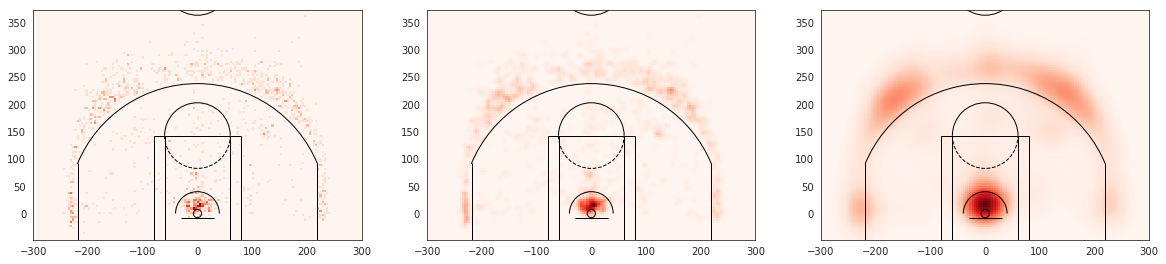

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(20,60))

plot_shotchart(binned_counts = curry_binned_unsmoothed[0], xedges = xedges, yedges = yedges, ax = ax[0]);
plot_shotchart(binned_counts = curry_binned_smoothed1[0], xedges = xedges, yedges = yedges, ax = ax[1]);
plot_shotchart(binned_counts = curry_binned_smoothed5[0], xedges = xedges, yedges = yedges, ax = ax[2]);

### 4c Vectorizing Shot Images

- Here we proceed create a dictionary of smoothed patterns, each vectorized into a 1-d array. 
- In this case, the object `all_smooth` is a dictionary that consists of arrays of length `15750`. 
- Each entry in `all_smooth` represents the smoothed frequency of shots along the bins generated in the code above for a given player.

In [37]:
## number of bins is one less than number of edges (remember homework 1)
nx = xedges.size - 1
ny = yedges.size - 1

## 2d histogram containers for binned counts and smoothed binned counts
all_counts = []
all_smooth = []
pids = []

## 2d histogram containers for binned counts and smoothed binned counts

## data matrix: players (row) by vectorized 2-d court locations (column)
for i, one in enumerate(allshots.groupby('PlayerID')):
    
    ## what does this line do?
    pid, pdf = one
        
    num_shots = len(pdf.index)
    if(num_shots > 100): 
        
        tmp1, xedges, yedges = bin_shots(pdf, bin_edges=(xedges, yedges), density=True, sigma=2)
        tmp2, xedges, yedges = bin_shots(pdf, bin_edges=(xedges, yedges), density=False)
    
        ## vectorize and store into list
        all_smooth += [tmp1.reshape(-1)]
        all_counts += [tmp2.reshape(-1)]
        pids += [pid]

In [38]:
X = np.vstack(all_smooth).T
p, n = X.shape

print('Number of shot regions (p):', p)
print('Number of players (n):', n)

Number of shot regions (p): 15750
Number of players (n): 388


## Question 5: Non-negative Matrix Factorization (NMF) 

The non-negative matrix factorization is a dimension reduction technique that is often applied to image data.  It is similar to PCA except that is only applicable for strictly positive data.  We can apply the NMF to vectorized versions of the shot surface. This is useful because we can conver the observed matrix of shot surfaces into:
* Bases: Identifying modes of shooting style (number of modes is determined by `n_components` argument to `NMF` function below)
* Coefficients: How each players shooting style could be expressed as a (positive) linear combination of these bases

The NMF solves the following problem: given some matrix $X$ is $p\times n$ matrix, NMF computes the following factorization:
$$ \min_{W,H} \| X - WH \|_F\\
\text{ subject to } W\geq 0,\ H\geq 0, $$
where $W$ is ${p\times r}$ matrix and $H$ is ${r\times n}$ matrix.

In this homework, we have the following:
 
#### The data matrix $X$ 
$X$ is of dimension $n$={number of players} and $p$={number of total square bins on the court}. Each column corresponds to a player, with entries corresponding to a "flattened" or "vectorized" version of the 2d histograms plotted in part 4b.

#### Bases matrix: $W$

Columns $W_i$ contain the shot "bases". First, we will try it with $r=3$ bins in 5a, and then with $r=10$ bins in 5d.

#### Coefficient matrix: H

Each column of $H$ gives a coefficient for each of the bases vectors in $W$, and there are $n$ columns for each player.


The `sklearn` library is one of the main Python machine learning libraries.  It has a built in NMF function for us.  The function below runs this function and normalizes the basis surfaces to sum to 1.

In [39]:
## Non-negative Matrix Factorization
def non_negative_matrix_decomp(n_components, array_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, init='nndsvda', max_iter=500, random_state=0)
    W = model.fit_transform(array_data)
    
    # Normalize basis vectors to sum to 1
    Wsum = W.sum(axis=0)
    W = W/Wsum
    
    ## fix H correspondingly
    H = model.components_
    H = (H.T * Wsum).T

    nmf = (W, H)
    return(nmf)

### Q5a

Compute the NMF on all player's shot charts, X, assuming with `n_components` = 3 (i.e. each shot chart can be represented as a positive linear combination of 3 "basis" shot charts).  Fill in `plot_vectorized_shot_chart`.  This takes a the a vector of binned shot counts, converts it back to a matrix of the appropriate size and then calls `plot_shotchart` on the matrix.  The numpy function `reshape` will be useful here: [https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)

In [40]:
W, H = non_negative_matrix_decomp(n_components = 3, array_data = X)

In [41]:
def plot_vectorized_shotchart(vec_counts, xedges, yedges, ax=None, use_log=False, cmap = 'Reds'):
    
    """Plots 2d heatmap from vectorized heatmap counts
    
    Args:
        hist_counts: vectorized output of numpy.histogram2d
        xedges, yedges: bin edges in arrays
        ax: figure axes [None]
        use_log: will convert count x to log(x+1) to increase visibility [False]
        cmap: Set the color map https://matplotlib.org/examples/color/colormaps_reference.html
    Returns:
        ax: axes with plot
    """

    nx = xedges.size - 1
    ny = yedges.size - 1
    
    # use reshape to convert a vectorized counts back into a 2d histogram
    two_d_counts = vec_counts.reshape((nx, ny))
    
    return(plot_shotchart(two_d_counts, xedges, yedges, ax=ax, use_log=use_log, cmap=cmap))



### Q5b

Plot the first three basis images by calling `plot_vectorized_shot_chart` on the columns of W3.

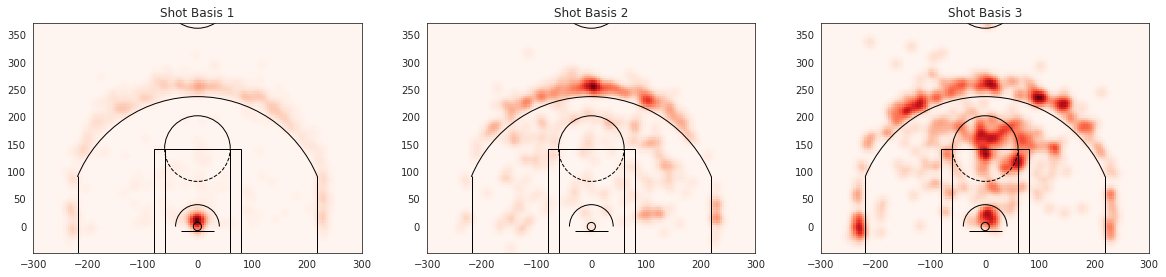

In [42]:

fig, ax = plt.subplots(1, 3, figsize=(20,60))

## Write a for loop
for i in range(3):
    # Call plot_vectorized_shot_chart
    plot_vectorized_shotchart(vec_counts = X[:,i], xedges = xedges, yedges = yedges, ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))

### Q5b
Below we re-construct the shooting pattern for a single player. By "reconstructing" we mean use the approximation $$\hat{X} = WH$$ obtained via NMF.  Find $\hat X$ by multipling W and H.  In python the `@` symbol is used for matrix multiplication.

In [43]:
X3_hat = W @ H
X3_hat.shape

(15750, 388)


Plot $X$, $\hat X$ and the residual ($X - \hat X$) for the player named LaMarcus Aldridge. Remember, each column of $X$ is a vectorized matrix corresponding to the binned (or smoothed binned) shot information.

0.0007131954341844194


Text(0.5, 1.0, 'Residual Shooting Pattern (r=3)')

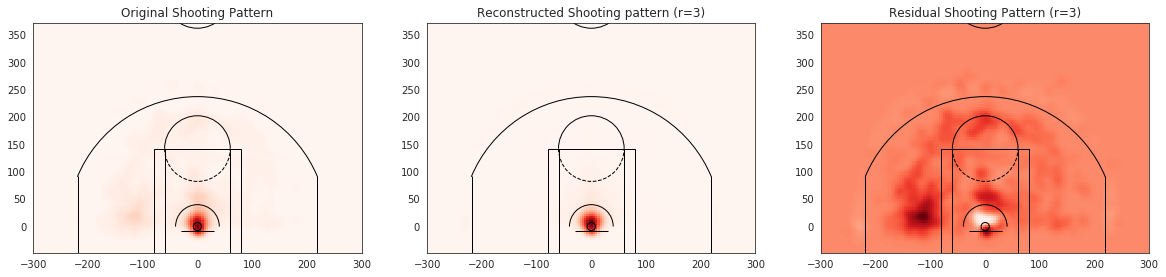

In [44]:
# Find the player_id of LaMarcus Aldridge
player_id = allplyrs.index[allplyrs.DISPLAY_FIRST_LAST == "LaMarcus Aldridge"]

## find index in X corresponding to that player
to_plot_idx = np.where(pids == player_id)[0][0]

fig, ax = plt.subplots(1, 3, figsize=(20,60))

## Call plot_vectorized_shot_chart
original_shotchart = plot_vectorized_shotchart(vec_counts = X[:,to_plot_idx], xedges = xedges, yedges = yedges, ax = ax[0])
reconstructed_shotchart = plot_vectorized_shotchart(vec_counts = X3_hat[:,to_plot_idx], xedges = xedges, yedges = yedges, ax = ax[1])
residual_chart = plot_vectorized_shotchart(vec_counts = X[:,to_plot_idx] - X3_hat[:,to_plot_idx], xedges = xedges, yedges = yedges, ax = ax[2])

print(max(abs(X3_hat[:, to_plot_idx] - X[:, to_plot_idx])))
ax[0].set_title('Original Shooting Pattern')
ax[1].set_title('Reconstructed Shooting pattern (r=3)')
ax[2].set_title('Residual Shooting Pattern (r=3)')

### Q5c

Why does it make sense to use a _sequential_ palette for the original and reconstructed shot charts and a _diverging_ palette for the residual?  _Hint:_ Read the introduction to colormaps [here](https://matplotlib.org/users/colormaps.html). 

A sequential palette is usefull for identifying lows and highs. A diverging palette helps us identify values that deviate from zero. Diverging from white to red (high) and blue (low) tends to be a common way to represent anommalies or residuals.

What areas of the court does this player to shoot more and where less relative to the reconstructed area.  If its helpful, you can refer to court locations by name using this legend [here](https://en.wikipedia.org/wiki/Basketball_court#/media/File:Basketball_terms.png]).

The player spends less time near the ring that what the reconstruction shows. The reconstruction also ignores the time the player spends on the lef-side of the court, around coords (-100, 0).

#### Q5d

Re-run the analysis, this time for 10 basis vectors instead of 3.  Again plot the bases using `plot_vectorized_shotchart` on the columns of `W10`.

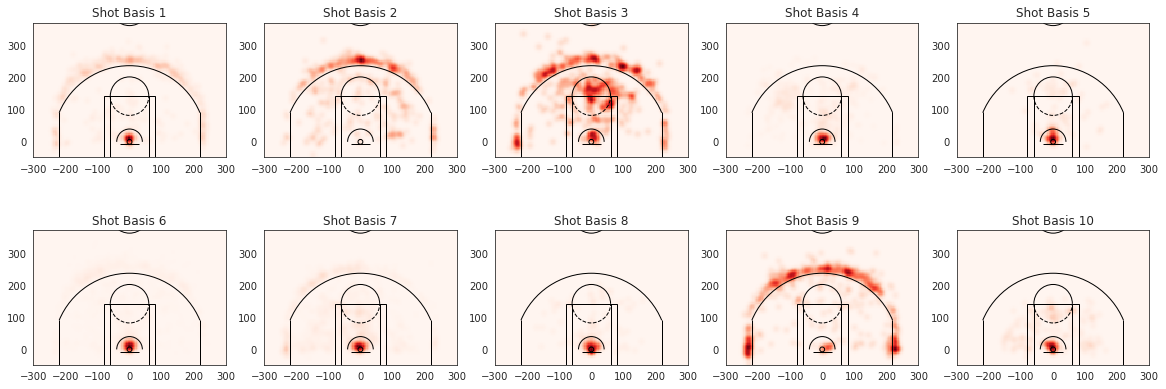

In [45]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))

## Write a for loop
for i in range(10):
    ax[i//5, i % 5].set_title('Shot Basis %i' % (i+1))
    plot_vectorized_shotchart(vec_counts = X[:,i], xedges = xedges, yedges = yedges, ax = ax[i//5, i % 5])

If you did things correctly, you should be really impressed! We've identified potentially interesting patterns of shooting styles without actually specifying anything about the way basketball is played or where the relevant lines are on the court.  The resulting images are based only on the actual behavior of the players.  Even more impressive is that we're capturing similarity in regions that are far apart on the court.  One reason we can do this is that a basketball court is symmetric along the length of the court (i.e. symmetric about x=0).  However, people tend to be left or right hand dominant, which might affect their preferences.  Look carefuly at the shot basis plots above: is there any evidence of _asymmetry_ in player shooting behavior?  Refer to specific basis images in your answer.    

Shot Basis 2 shows a higher presence of shots on the right side around coords (100, 250). Shot basus 3 shows a greater concentration on shots around coords (100, 120). Shot basis 7 shows more 3-point shots on the left than on the side (i.e. coords X < 0).

Repeat part 5b, and again plot original, reconstructed and residual shot chats for LaMarcus Aldridge.

0.0006216431331162522


Text(0.5, 1.0, 'Residual Shooting Pattern (r=10)')

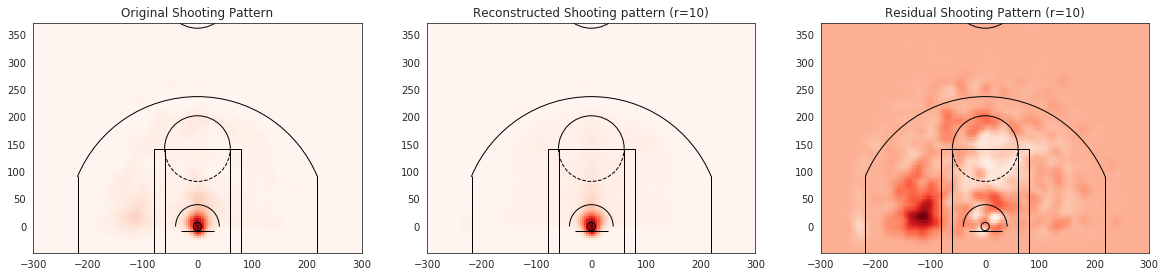

In [46]:
W10, H10 = non_negative_matrix_decomp(n_components = 10, array_data = X)
X10_hat = W10 @ H10

# Find the player_id of LaMarcus Aldridge
player_id = allplyrs.index[allplyrs.DISPLAY_FIRST_LAST == "LaMarcus Aldridge"]

## find index in X corresponding to that player
to_plot_idx = np.where(pids == player_id)[0][0]

fig, ax = plt.subplots(1, 3, figsize=(20,60))

## Call plot_vectorized_shot_chart
original_shotchart = plot_vectorized_shotchart(vec_counts = X[:,to_plot_idx], xedges = xedges, yedges = yedges, ax = ax[0])
reconstructed_shotchart = plot_vectorized_shotchart(vec_counts = X10_hat[:,to_plot_idx], xedges = xedges, yedges = yedges, ax = ax[1])
residual_chart = plot_vectorized_shotchart(vec_counts = X[:,to_plot_idx] - X10_hat[:,to_plot_idx], xedges = xedges, yedges = yedges, ax = ax[2])

# I took the first player appearing in first column 
# (you probably want to do more interesting players)
original_shotchart = ...
reconstructed_shotchart = ...
residual_chart = ...

print(max(abs(X10_hat[:, to_plot_idx] - X[:, to_plot_idx])))
ax[0].set_title('Original Shooting Pattern')
ax[1].set_title('Reconstructed Shooting pattern (r=10)')
ax[2].set_title('Residual Shooting Pattern (r=10)')

### Q5g: Next steps

One of the main purposes of exploratory data analysis is to generate new ideas, directions, and hypothesis for future analyses and experiments.  What did you see in this analysis that piqued your interest? What are some directions for follow up analyses that you could do based on what you found in this analysis? What types of tools (programming, statistical or otherwise) would you need for this analysis.  What additional data might you need? Discuss in a paragraph below.

I am not sure about basketball, but the use of NMF for spatial patterns certainly spiked my interest. Part of my research focuses on tracking about 50,000 fishing vessels worlwide. These vessels transmit their positions every 10 s - 5 minutes, which allows me to perform similar analyses. I intend to use NMF to explore habitat utilization patterns by fishing vessels.

## Question 6 (PSTAT 234): Analyzing players' styles

### Q6a: prepare coefficients

Matrix `H10` describe each player's shooting style in terms of the 10 shooting styles NMF extracted from data. First create a data frame `Hnew` with `H10` so that each column is for a player. Set row names with `shot_type_names` and column names with players' names.

<!--
BEGIN QUESTION
name: q6a
manual: false
points: 3
-->

In [47]:
shot_type_names = ['basis'+str(i) for i in range(1,11)]
Hnew = pd.DataFrame(H10, index = shot_type_names)
grouped_shots = allshots.groupby(['PLAYER_ID','PLAYER_NAME'], as_index = False).agg({"SHOT_MADE_FLAG": "size"})
names = grouped_shots.PLAYER_NAME[grouped_shots.SHOT_MADE_FLAG > 100]
Hnew.columns = names
Hnew

PLAYER_NAME,Vince Carter,Dirk Nowitzki,Jamal Crawford,Tony Parker,Nene,LeBron James,Dwyane Wade,Zaza Pachulia,Kyle Korver,Shaun Livingston,...,Kenrich Williams,Trae Young,Deandre Ayton,Luka Doncic,Elie Okobo,Rodions Kurucs,Gary Clark,Jaylen Adams,Johnathan Williams,Ryan Broekhoff
basis1,0.091494,0.000000,0.000000,0.120083,0.143257,0.154360,0.087402,0.065687,0.000000,0.114657,...,0.101515,0.168446,0.192983,0.069071,0.070737,0.152468,0.036025,0.019729,0.157882,0.027743
basis2,0.109813,0.049537,0.063741,0.003020,0.000000,0.000000,0.079777,0.000000,0.233682,0.000000,...,0.169386,0.000000,0.000000,0.000534,0.044229,0.103061,0.337275,0.097545,0.000000,0.338450
basis3,0.015274,0.001987,0.000063,0.000000,0.057410,0.035813,0.024662,0.218737,0.006516,0.071592,...,0.046236,0.000000,0.196909,0.038760,0.051833,0.082009,0.009799,0.000000,0.290608,0.026153
basis4,0.324068,0.473023,0.215717,0.000989,0.000000,0.112180,0.092110,0.000000,0.343721,0.000000,...,0.006580,0.179374,0.000000,0.185987,0.191652,0.103876,0.016999,0.330881,0.000000,0.156524
basis5,0.005076,0.000000,0.014497,0.143854,0.044880,0.090399,0.056537,0.202225,0.033010,0.020596,...,0.132304,0.053839,0.079638,0.071654,0.060753,0.215392,0.000000,0.043941,0.000000,0.083059
basis6,0.011138,0.000000,0.000308,0.042998,0.081269,0.065057,0.119322,0.143478,0.000000,0.131514,...,0.071941,0.000521,0.087396,0.074314,0.158629,0.039764,0.009292,0.041873,0.206016,0.040488
basis7,0.015916,0.005840,0.024713,0.113851,0.186925,0.018360,0.118054,0.053119,0.000000,0.101350,...,0.035941,0.099478,0.118211,0.151070,0.046451,0.013422,0.003389,0.020709,0.136735,0.009866
basis8,0.067488,0.349247,0.558938,0.410076,0.286424,0.155480,0.292449,0.242271,0.115701,0.529514,...,0.024113,0.198328,0.306238,0.099953,0.188388,0.000000,0.000000,0.048266,0.000000,0.013599
basis9,0.058560,0.000000,0.027601,0.105025,0.250163,0.175735,0.044634,0.140274,0.000000,0.068251,...,0.009509,0.111382,0.051186,0.040248,0.000000,0.100345,0.004396,0.080655,0.321186,0.023513
basis10,0.252141,0.075730,0.159337,0.076543,0.000000,0.152383,0.091116,0.000000,0.195395,0.000000,...,0.389689,0.135153,0.000000,0.220517,0.236687,0.263809,0.680581,0.374551,0.000000,0.312133


In [48]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q6a > Suite 1 > Case 1

>>> Hnew.columns
Index(['Vince Carter', 'Dirk Nowitzki', 'Jamal Crawford', 'Tony Parker',
       'Nene', 'LeBron James', 'Dwyane Wade', 'Zaza Pachulia', 'Kyle Korver',
       'Shaun Livingston',
       ...
       'Kenrich Williams', 'Trae Young', 'Deandre Ayton', 'Luka Doncic',
       'Elie Okobo', 'Rodions Kurucs', 'Gary Clark', 'Jaylen Adams',
       'Johnathan Williams', 'Ryan Broekhoff'],
      dtype='object', name='PLAYER_NAME', length=388)

# Error: expected
#     Index(['Vince Carter', 'Dirk Nowitzki', 'Jamal Crawford', 'Tony Parker',
#            'Nene', 'LeBron James', 'Dwyane Wade', 'Zaza Pachulia', 'Kyle Korver',
#            'Shaun Livingston',
#            ...
#            'Kenrich Williams', 'Trae Young', 'Deandre Ayton', 'Luka Doncic',
#            'Elie Okobo', 'Rodions Kurucs', 'Gary Clark', '

### Q6b: visualizing correlations

Correlations of players' coefficients would identify similar or different shooting styles. Compute the correlation using [an appropriate Pandas function](https://pandas.pydata.org/pandas-docs/stable/reference/). Make sure to use a diverging color palette and set the aspect ratio to be square.

<!--
BEGIN QUESTION
name: q6b
manual: false
points: 3
-->

In [ ]:
Rnew = ...

plt.figure(figsize=(18,18))
...

In [ ]:
ok.grade("q6b");

The heatmap gives some indication that we might be able to distinguish players from each other by their composition of shooting styles. It would be great if we can permute the rows and columns of the matrix to help us distinguish similar players better. In order to accomplish this, we will use a function from hierarchical clustering.

In [ ]:
from scipy.cluster.hierarchy import linkage, leaves_list
Hnew_linkage = linkage(Hnew.transpose(), optimal_ordering=True)
leave_ord = leaves_list(Hnew_linkage)

plt.figure(figsize=(18,18))
sns.heatmap(Rnew.iloc[leave_ord, leave_ord], square=True, cmap="coolwarm")

### Q6c: Player entropy: Specialist or Generalist? 

Compute each player's entropy. In information theory, entropy is defined by:
$$ \text{Entropy} = - \sum_i p_i\,\log(p_i) $$
In order to compute Entropy, each column (player)'s coefficients are normalized. 

1. Define a [lambda function](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) `vec_normalize` that normalizes a vector: i.e., elements of the vector sums to 1. 
2. Then, use it along with `apply` method to standardize each column of `Hnew`. Save the result as `Hnorm`.
3. Define another lambda function called `vec_normalize` for entropy computation.
4. Use it along with `apply` method to compute entropy for each player. Save the result as `entropy`.

<!--
BEGIN QUESTION
name: q6c1
manual: false
points: 3
-->

In [ ]:
vec_normalize = ...
Hnorm = ...

vec_entropy = ...
entropy = ...

In [ ]:
ok.grade("q6c1");

Find a generalist and a specialist in this context. In a few sentences, compare their shooting styles.

<!--
BEGIN QUESTION
name: q6c2
manual: true 
points: 3
-->
<!-- EXPORT TO PDF -->

**Solution Here**

### Q6d: Player similarity vs dissimilarity

`Rnew` can be used to identify players that are similar or dissimilar respect to any chosen player. Find players most similar to `Stephen Curry` by searching for players with correlation greater than 0.92. Note that the most `Stephen Curry` will be included since any players' correlation to themselves is perfect: i.e. correlation of 1. Repeat the procedure for `Bismack Biyombo` in order to identify players with correlation greater than 0.9.
<!--
BEGIN QUESTION
name: q6d1
manual: false
points: 2
-->

In [ ]:
curry_like = ...

In [ ]:
ok.grade("q6d1");

<!--
BEGIN QUESTION
name: q6d2
manual: false
points: 2
-->

In [ ]:
biyo_like = ...

In [ ]:
ok.grade("q6d2");

In [ ]:
figure = plt.figure(figsize=(20,5))

## Plot for Curry-like players
figure.add_subplot(1, 2, 1)
...

## Plot for Biyombo-like players
figure.add_subplot(1, 2, 2)
...
plt.show()

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 1 EXPORTED QUESTIONS -->

In [50]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('homework2.ipynb', 'homework2.pdf')
ok.submit()

Generating PDF...


/opt/conda/lib/python3.6/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.7.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/opt/conda/lib/python3.6/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.7.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/opt/conda/lib/python3.6/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.7.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/opt/conda/lib/python3.6/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsu

Saved homework2.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'homework2.ipynb'.
Submit... 100% complete
Submission successful for user: juancarlos@ucsb.edu
URL: https://okpy.org/ucsb/pstat134234/sp19/homework2/submissions/WLXPwX

